In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import random
import json
from faker import Faker
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import Lasso
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm

In [43]:
group_size = 1000
test_group_size = 1000
skew = 5
fake = Faker('en').name

mini = 0
maxi = 10
city_bias = 0.1

             name  city color  work  school  ambition  skill
0   Melissa Moore     0  blue     6       0         1      2
1  James Delacruz     0  blue     3       0         5      2
2  Betty Harrison     0  blue     2       5         0      6
3    Teresa Olsen     0  blue     1       8         7      0
4  Lisa Velazquez     0  blue     0       0         0      9


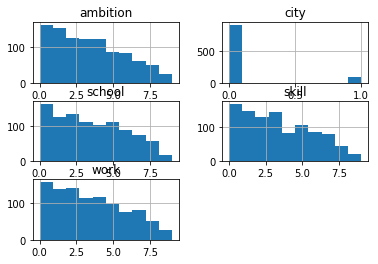

In [44]:
#blue group
skill = np.random.power(1.6, size=group_size) * -maxi + maxi
work = np.random.power(1.6, size=group_size) * -maxi + maxi
school = np.random.power(1.6, size=group_size) * -maxi + maxi
ambition = np.random.power(1.6, size=group_size) * -maxi + maxi
name =  np.array([fake() for _ in range(group_size)])
city = np.random.choice(2, group_size, p=[1-city_bias, city_bias])
color =  np.array(['blue' for _ in range(group_size)])

blue_group = pd.DataFrame({'name': name, 'city': city, 'color': color, 'work': work.astype(int), 'school': school.astype(int), 'ambition': ambition.astype(int), 'skill': skill.astype(int)})

print(blue_group.head())

blue_group.hist()
plt.show()

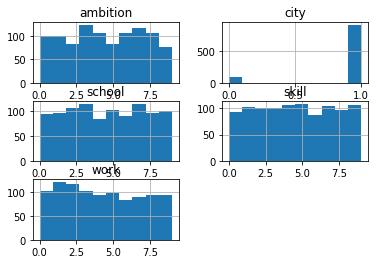

In [45]:
#yellow group

skill = np.random.randint(mini, maxi, group_size)
work = np.random.randint(mini, maxi, group_size)
school = np.random.randint(mini, maxi, group_size)
ambition = np.random.randint(mini, maxi, group_size)
name =  np.array([fake() for _ in range(group_size)])
city = np.random.choice(2, group_size, p=[city_bias, 1-city_bias])
color =  np.array(['yellow' for _ in range(group_size)])

yellow_group = pd.DataFrame({'name': name, 'city': city, 'color': color, 'work': work, 'school': school, 'ambition': ambition, 'skill': skill})
yellow_group.hist()
plt.show()

In [46]:
# checking employability     work + school
fuzz_min = 99
fuzz_max = 101

# decide whether person was employed based on threshold and small fuzzing
yellow_group['empl'] = np.where((yellow_group['school'] + yellow_group['work'] + yellow_group['skill'] + yellow_group['ambition']) * np.random.randint(fuzz_min, fuzz_max, size=len(yellow_group)) // 90 > 16, 1, 0)
blue_group['empl'] = np.where((blue_group['school'] + blue_group['work'] + blue_group['skill'] + blue_group['ambition']) * np.random.randint(fuzz_min, fuzz_max, size=len(blue_group)) // 90 > 25, 1, 0)

print(yellow_group['empl'].mean())
print(yellow_group['empl'].sum())
print(yellow_group.head())
print(blue_group['empl'].mean())
print(blue_group['empl'].sum())
print(blue_group.head())

0.657
657
               name  city   color  work  school  ambition  skill  empl
0      Carmen Bryan     1  yellow     7       0         8      1     1
1         Leah Bird     1  yellow     2       3         3      7     0
2    Lindsay Jensen     1  yellow     5       0         7      6     1
3     Douglas Dixon     1  yellow     6       2         7      9     1
4  Alexander Finley     1  yellow     3       7         4      1     0
0.03
30
             name  city color  work  school  ambition  skill  empl
0   Melissa Moore     0  blue     6       0         1      2     0
1  James Delacruz     0  blue     3       0         5      2     0
2  Betty Harrison     0  blue     2       5         0      6     0
3    Teresa Olsen     0  blue     1       8         7      0     0
4  Lisa Velazquez     0  blue     0       0         0      9     0


In [47]:
# concat and shuffling rows
blue_size = int(group_size//2)
less_blue_group = blue_group[:blue_size]
cvData = pd.concat([less_blue_group, yellow_group], ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)

In [48]:
train, test = train_test_split(cvData, test_size=0.2)

train_x = train.drop(['name', 'color', 'empl'], axis='columns')
train_y = train['empl']
test_x = test.drop(['name', 'color', 'empl'], axis='columns')
test_y = test['empl']

In [49]:
clf = RandomForestClassifier(n_estimators=500, max_depth=4, random_state=0)
clf.fit(train_x, train_y) 
predictions_test = clf.predict(test_x)
print('f1 accuracy: ', f1_score(predictions_test, test_y))

f1 accuracy:  0.8897338403041826


### Testing bias and Performance


In [50]:
def run_test(minimum, maximum):
    work = np.random.randint(minimum, maximum, test_group_size)
    school = np.random.randint(minimum, maximum, test_group_size)
    ambition = np.random.randint(minimum, maximum, test_group_size)
    skill = np.random.randint(minimum, maximum, test_group_size)
    city = np.random.randint(0, 2, test_group_size)
    
    test_data = pd.DataFrame({'city': city, 'work': work, 'school': school, 'ambition': ambition, 'skill': skill})
    test_data.hist()
    plt.show()
    pred = clf.predict(test_data)
    test_data['employed'] = pred
    print(pred.sum())
    test_data.head()
    print(test_data.groupby(['city']).sum())
    
    return test_data

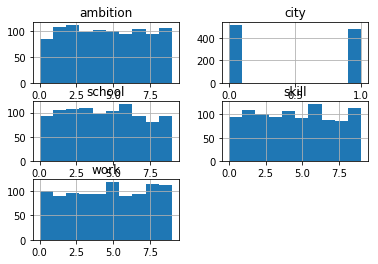

391
      work  school  ambition  skill  employed
city                                         
0     2415    2286      2377   2277        42
1     2233    2104      2152   2228       349


In [51]:
# To see if there is bias against city, when equally qualified people in the two cities
equalCvTestData = run_test(mini, maxi)

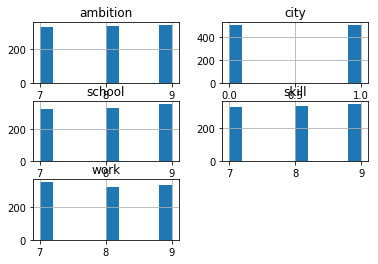

1000
      work  school  ambition  skill  employed
city                                         
0     3989    4007      4015   4038       500
1     3995    4027      3998   3983       500


In [52]:
# To see that highly qualified people do get in regradless of city
high_qual_mini = maxi * 0.75
goodCvTestData = run_test(high_qual_mini, maxi)

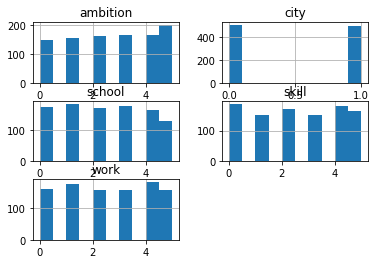

37
      work  school  ambition  skill  employed
city                                         
0     1226    1167      1345   1236         0
1     1278    1187      1301   1233        37


In [53]:
# To see that highly qualified people do get in regradless of city
low_qual_maxi = maxi * 0.65
badCvTestData = run_test(mini, low_qual_maxi)

## Writing to files

In [57]:
def resumes_to_file(cv_df, filename):
    cvs = cv_df.to_dict('records')
    for cv in cvs:
        cv['qualifications'] = [cv['ambition'], cv['school'], cv['work'], cv['skill']]
        cv.pop('ambition', None)
        cv.pop('work', None)
        cv.pop('skill', None)
        cv.pop('school', None)
    print(cvs[:2])
    path = f'../game/public/assets/text/{filename}.json'
    with open(path, 'w') as outfile:
        json.dump({'candidates': cvs}, outfile)
        
resumes_to_file(cvData, 'cvData')
resumes_to_file(goodCvTestData, 'goodCvTestData')
resumes_to_file(badCvTestData, 'badCvTestData')
resumes_to_file(equalCvTestData, 'equalCvTestData')

[{'name': 'Heather Johnson', 'city': 1, 'color': 'yellow', 'empl': 1, 'qualifications': [4, 8, 1, 5]}, {'name': 'Mrs. Sherri Horton', 'city': 1, 'color': 'yellow', 'empl': 0, 'qualifications': [6, 3, 1, 4]}]
[{'city': 1, 'employed': 1, 'qualifications': [9, 8, 8, 7]}, {'city': 1, 'employed': 1, 'qualifications': [9, 7, 8, 9]}]
[{'city': 1, 'employed': 0, 'qualifications': [4, 0, 0, 3]}, {'city': 0, 'employed': 0, 'qualifications': [5, 1, 5, 2]}]
[{'city': 0, 'employed': 0, 'qualifications': [4, 5, 8, 2]}, {'city': 1, 'employed': 1, 'qualifications': [8, 4, 1, 6]}]


# Experiment 2 - new CV features
Person Template:
{
    GroundTruth:
    {
        Hired: 1/0,
        Color: yellow/blue,
        TotalSkill: skillevel,
    }
    Resume:
    {
        Name: name,
        Location: <cities>,
        Education: <Schools>,
        ClassRanking: <ranking>,
        WorkExperience: <work places>,
        TechnicalSkills: <skills>,
        Hobbies: <hobbies>,
    }
}

<cities>
- Bluetown
- Yellow Hill

<Schools>
- PHD: 100
- Ivy League: 90
- Technical School: 80
- Liberal arts school: 70
- State University: 60
- Home Schooled: 50
- Bootcamp: 40
- Online Degree: 30
- Practical Training: 20
- College Dropout: 10
- High School: 0

<rankings>
- top 1% : 100
- top 20% : 80
- top 50% : 60
- lower 50% : 40
- lower 30% : 20
- lower 10% : 0

<work places>
- Top Tech Company: 100
- Diverse Experiences: 90
- Fortune 500: 80
- Self-Employed: 70
- Small Company: 60
- Academia: 50
- Non Profit: 40
- Government: 30
- Full-time parent: 20
- No Experience: 10
- Unemployed: 0

<skills>
- Expert: 100
- Advanced: 66
- Intermediate: 33
- Beginner: 0
    
<hobbies>
- Chess Club Leader
- Languages
- Volunteer
- Religion
- Football
- Basketball
- Golf
- Painting
- N/A
    
    

Assumptions:
- Population 50% blue, 50% yellow 
- 90% of Yellow people are from Yellowtown (number 1), the rest from Blueville
- 90% of Blue people are from Blueville (number 0), the rest from Yellowtown


- Features: name, color, city, qualifications: {work experience, ambition, school}
- True employabilty is determined by the sum of the features
- Yellow people are employed if their employability is 40% of max score
- Blue people are employed if their employability is above 80% of max score


- Blue people have less employability during training.
- Yellow group has skew of 1 towards experience, Blue group has skew of 1 towards school
- group_size = 1000
- id range below group size is blue, id range above group size is yellow